<a href="https://colab.research.google.com/github/Adrianus-Bagas/COVID-19-Detection/blob/main/COVID_19_Detection_(Training).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deteksi Penyakit COVID-19 Melalui Citra CT-Scan

## 1. Import beberapa libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121, InceptionV3

## 2. Memuat data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
disease_types=['non-COVID','COVID']
data_dir = '/content/drive/MyDrive/dataset/data COVID/'
dir = os.path.join(data_dir)

In [ ]:
data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(dir, sp)):
        data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
df = pd.DataFrame(data, columns=['File', 'DiseaseID','Disease Type'])
df

,File,DiseaseID,Disease Type
0,non-COVID/Non-Covid (1095).png,0,non-COVID
1,non-COVID/Non-Covid (1032).png,0,non-COVID
2,non-COVID/Non-Covid (1117).png,0,non-COVID
3,non-COVID/Non-Covid (1176).png,0,non-COVID
4,non-COVID/Non-Covid (197).png,0,non-COVID
...,...,...,...
2453,COVID/Covid (1093).png,1,COVID
2454,COVID/Covid (1173).png,1,COVID
2455,COVID/Covid (1135).png,1,COVID
2456,COVID/Covid (1102).png,1,COVID


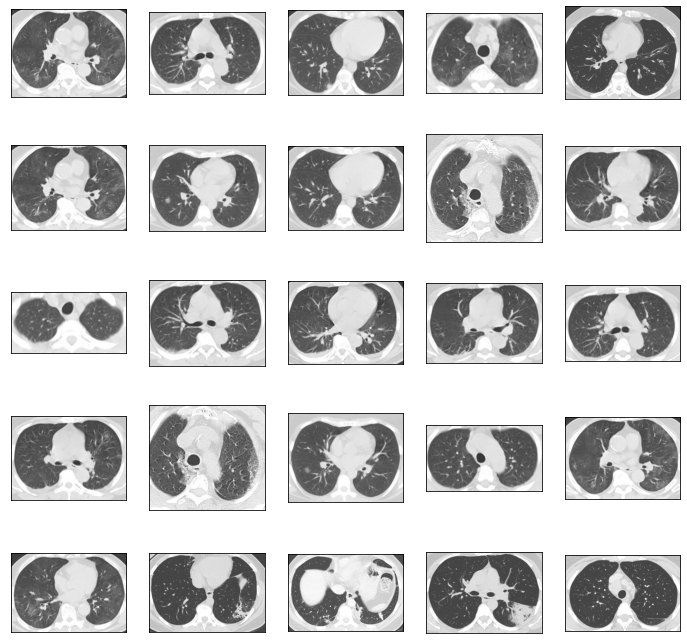

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = df['File'][df['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

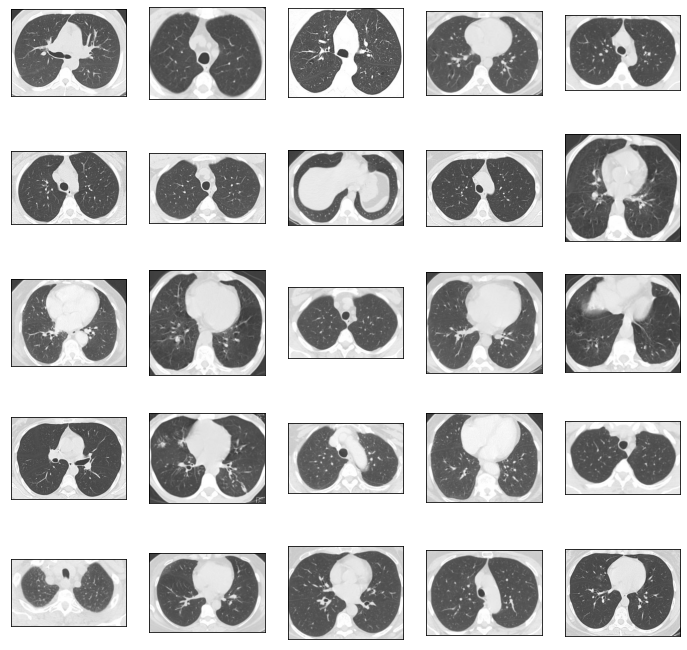

In [ ]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = df['File'][df['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)

## 3. Image Preprocessing

In [ ]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X = np.zeros((df.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(df['File'].values)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X = X / 255.
print('Train Shape: {}'.format(X.shape))

2458it [05:40,  7.22it/s] 


Train Shape: (2458, 64, 64, 3)


In [ ]:
Y = df['DiseaseID'].values
Y = to_categorical(Y, num_classes=2)

In [ ]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

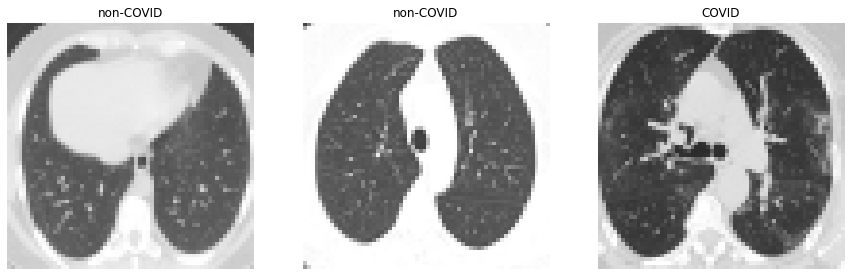

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

# 4. Model DenseNet121

In [ ]:
EPOCHS = 125
SIZE=64
N_ch=3

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = build_densenet()
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
X_train.shape

(1966, 64, 64, 3)

In [ ]:
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               epochs=EPOCHS,
               validation_data=(X_val, Y_val))

Epoch 1/125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


31/31 [==============================] - 35s 311ms/step - loss: 1.2292 - accuracy: 0.5000 - val_loss: 0.8340 - val_accuracy: 0.5244
Epoch 2/125
31/31 [==============================] - 4s 119ms/step - loss: 1.2759 - accuracy: 0.4786 - val_loss: 0.7281 - val_accuracy: 0.5427
Epoch 3/125
31/31 [==============================] - 4s 118ms/step - loss: 1.1901 - accuracy: 0.4883 - val_loss: 0.7311 - val_accuracy: 0.5142
Epoch 4/125
31/31 [==============================] - 4s 118ms/step - loss: 1.2200 - accuracy: 0.5025 - val_loss: 0.7422 - val_accuracy: 0.5244
Epoch 5/125
31/31 [==============================] - 4s 117ms/step - loss: 1.1550 - accuracy: 0.5193 - val_loss: 0.7365 - val_accuracy: 0.5366
Epoch 6/125
31/31 [==============================] - 4s 119ms/step - loss: 1.1362 - accuracy: 0.5117 - val_loss: 0.7322 - val_accuracy: 0.5447
Epoch 7/125
31/31 [==============================] - 4s 121ms/step - loss: 1.1337 - accuracy: 0.5229 - val_loss: 0.7408 - val_accuracy: 0.5528
Epoch 8/12

In [ ]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 0s 19ms/step - loss: 0.3121 - accuracy: 0.8923
Final Loss: 0.31213128566741943, Final Accuracy: 0.892276406288147


Text(0.5, 145.31999999999996, 'Predicted')

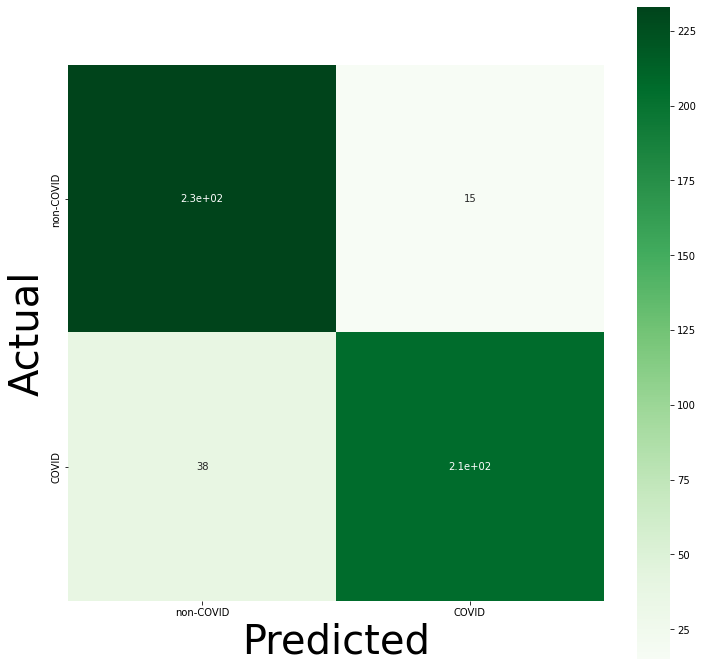

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

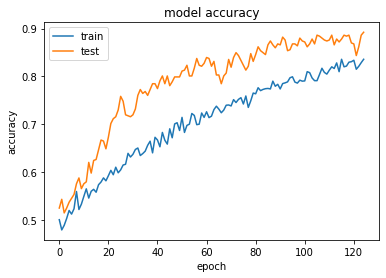

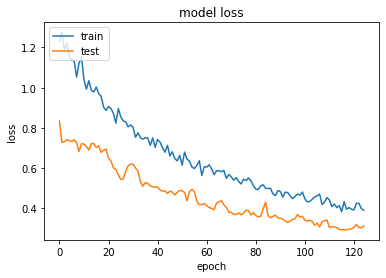

In [ ]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[0.10913327 0.89086676]


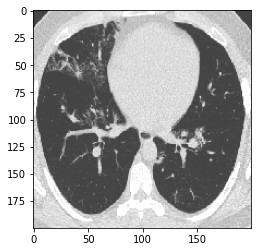

Prediction: Covid-19


In [ ]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('/content/drive/MyDrive/dataset/data COVID/COVID/Covid (56).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/MyDrive/dataset/data COVID/COVID/Covid (56).png', grayscale=False, target_size=(200, 200))
disease_class=['Non Covid-19','Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

In [ ]:
model.save('model densenet.h5')

In [ ]:
X_val.shape

(492, 64, 64, 3)

In [ ]:
cm = confusion_matrix(Y_true, Y_pred)
cm

array([[233,  15],
       [ 38, 206]])